# Inverse Transform Method: Theory and Implementation

This notebook provides a comprehensive introduction to the inverse transform method for random sampling, covering theoretical foundations, visual demonstrations, and practical implementations.

## Learning Objectives

After completing this notebook, you will:
- Understand the theoretical foundation of the inverse transform method
- Know when and why the method works
- Be able to implement both analytical and numerical versions
- Appreciate the trade-offs between different sampling methods
- Visualize how the transformation process works

In [5]:
# MC-Lab imports
import sys
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sys.path.insert(0, "../src")
from mc_lab._rng import as_generator
from mc_lab.inverse_transform import (
    NumericalInverseTransformSampler,
)

# Set style for consistent plots
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 11

# Fixed random seed for reproducibility
RANDOM_SEED = 42
rng = as_generator(RANDOM_SEED)

## 1. Theoretical Foundation

### The Fundamental Theorem

**If U ~ Uniform(0,1) and F is a CDF with inverse F⁻¹, then F⁻¹(U) follows the distribution with CDF F.**

### Mathematical Proof Sketch

For a continuous random variable X with CDF F(x), we want to show:

P(F⁻¹(U) ≤ x) = F(x)

**Proof:**
- Let Y = F⁻¹(U) where U ~ Uniform(0,1)
- We need: P(Y ≤ x) = P(F⁻¹(U) ≤ x)
- Since F is monotonic: F⁻¹(U) ≤ x ⟺ U ≤ F(x)
- Therefore: P(F⁻¹(U) ≤ x) = P(U ≤ F(x)) = F(x)

### Prerequisites
- Basic probability theory
- Understanding of cumulative distribution functions (CDFs)
- Uniform distribution properties

### When the Method Works
- F must be a valid CDF (monotonic non-decreasing, right-continuous)
- F⁻¹ must exist (at least as a generalized inverse)
- For practical implementation, we need either:
  - Analytical form of F⁻¹, or
  - Ability to compute F efficiently for numerical inversion

## 2. Visual Demonstration: Step-by-Step Transformation

Let's visualize how uniform random samples are transformed into samples from a target distribution.

Exponential Distribution (λ = 1.5)


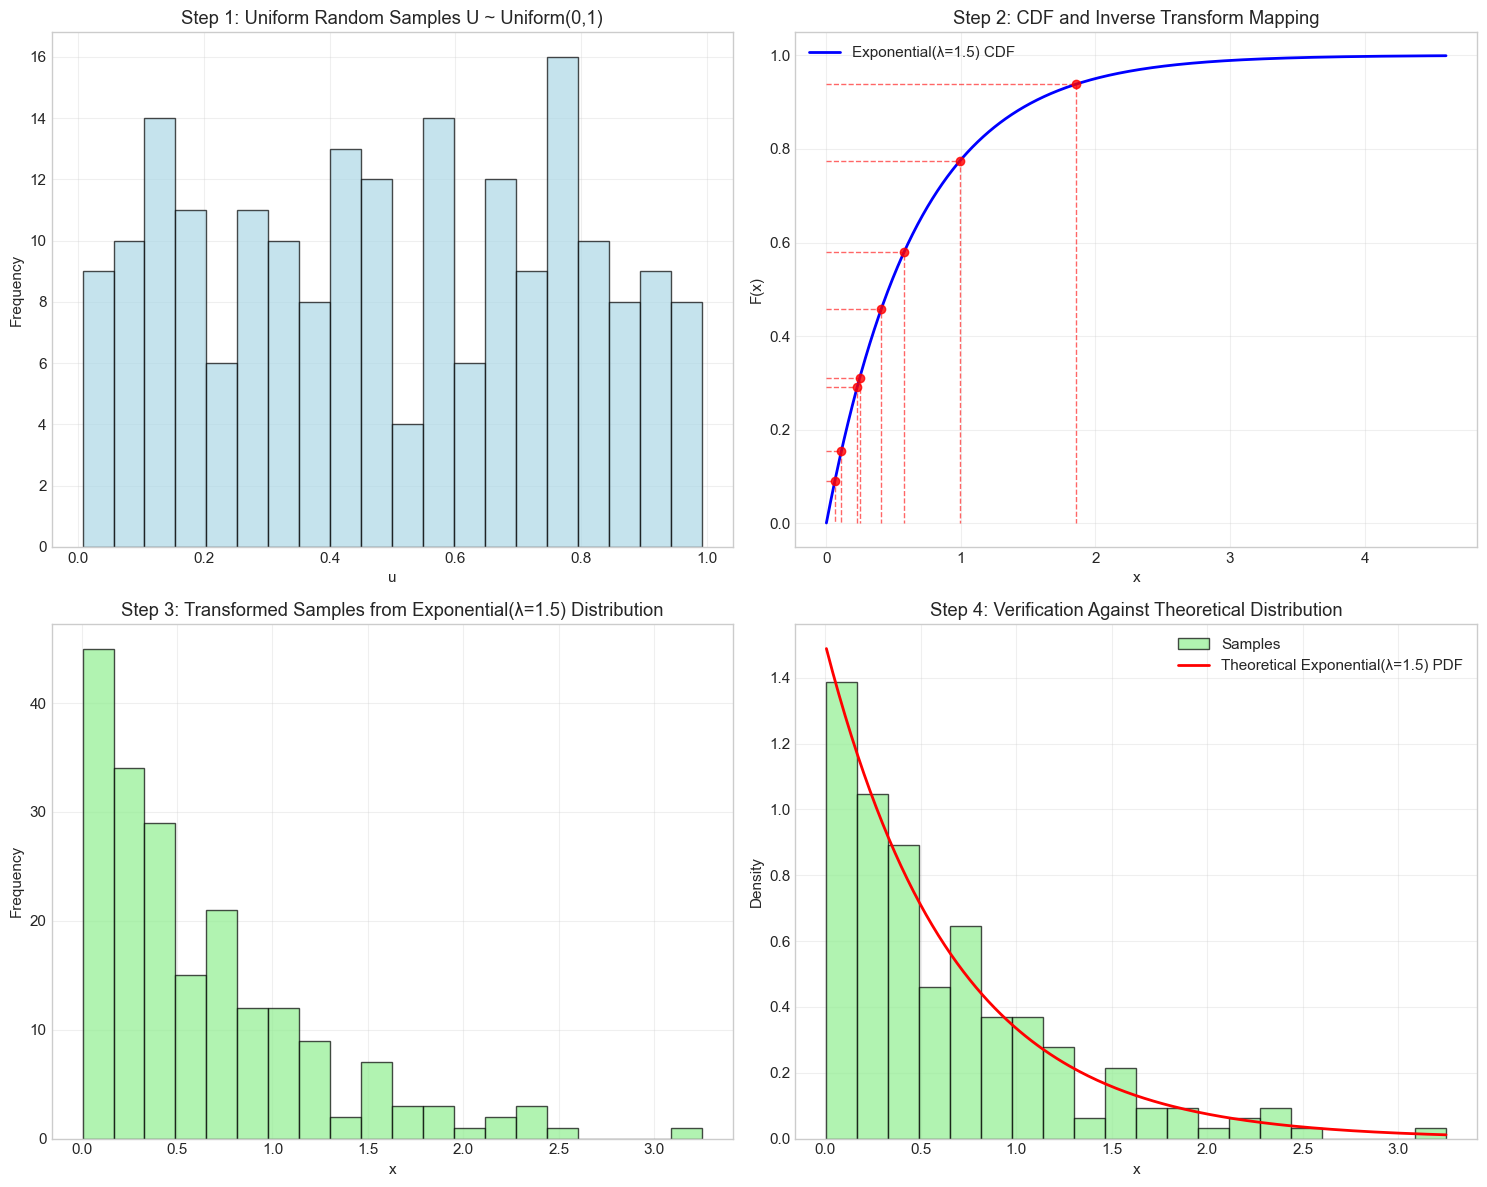

In [6]:
def visualize_inverse_transform(dist_name: str, dist_obj, n_samples: int = 100):
    """
    Create step-by-step visualization of the inverse transform process.
    """
    # Generate uniform samples
    u_samples = rng.uniform(0, 1, n_samples)

    # Transform using inverse CDF
    x_samples = dist_obj.ppf(u_samples)

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Uniform samples
    ax1.hist(u_samples, bins=20, alpha=0.7, color="lightblue", edgecolor="black")
    ax1.set_title("Step 1: Uniform Random Samples U ~ Uniform(0,1)")
    ax1.set_xlabel("u")
    ax1.set_ylabel("Frequency")
    ax1.grid(True, alpha=0.3)

    # 2. CDF visualization
    x_range = np.linspace(dist_obj.ppf(0.001), dist_obj.ppf(0.999), 1000)
    cdf_values = dist_obj.cdf(x_range)
    ax2.plot(x_range, cdf_values, "b-", linewidth=2, label=f"{dist_name} CDF")

    # Show transformation for a few sample points
    sample_indices = np.linspace(0, len(u_samples) - 1, 8, dtype=int)
    for i in sample_indices:
        u_val = u_samples[i]
        x_val = x_samples[i]
        ax2.plot(
            [dist_obj.ppf(0.001), x_val, x_val],
            [u_val, u_val, 0],
            "r--",
            alpha=0.6,
            linewidth=1,
        )
        ax2.plot(x_val, u_val, "ro", markersize=6, alpha=0.8)

    ax2.set_title("Step 2: CDF and Inverse Transform Mapping")
    ax2.set_xlabel("x")
    ax2.set_ylabel("F(x)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Transformed samples
    ax3.hist(x_samples, bins=20, alpha=0.7, color="lightgreen", edgecolor="black")
    ax3.set_title(f"Step 3: Transformed Samples from {dist_name} Distribution")
    ax3.set_xlabel("x")
    ax3.set_ylabel("Frequency")
    ax3.grid(True, alpha=0.3)

    # 4. Comparison with theoretical PDF
    x_theory = np.linspace(min(x_samples), max(x_samples), 200)
    pdf_theory = dist_obj.pdf(x_theory)
    ax4.hist(
        x_samples,
        bins=20,
        density=True,
        alpha=0.7,
        color="lightgreen",
        edgecolor="black",
        label="Samples",
    )
    ax4.plot(
        x_theory, pdf_theory, "r-", linewidth=2, label=f"Theoretical {dist_name} PDF"
    )
    ax4.set_title("Step 4: Verification Against Theoretical Distribution")
    ax4.set_xlabel("x")
    ax4.set_ylabel("Density")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Demonstrate with Exponential distribution
print("Exponential Distribution (λ = 1.5)")
exp_dist = stats.expon(scale=1 / 1.5)
visualize_inverse_transform("Exponential(λ=1.5)", exp_dist, 200)

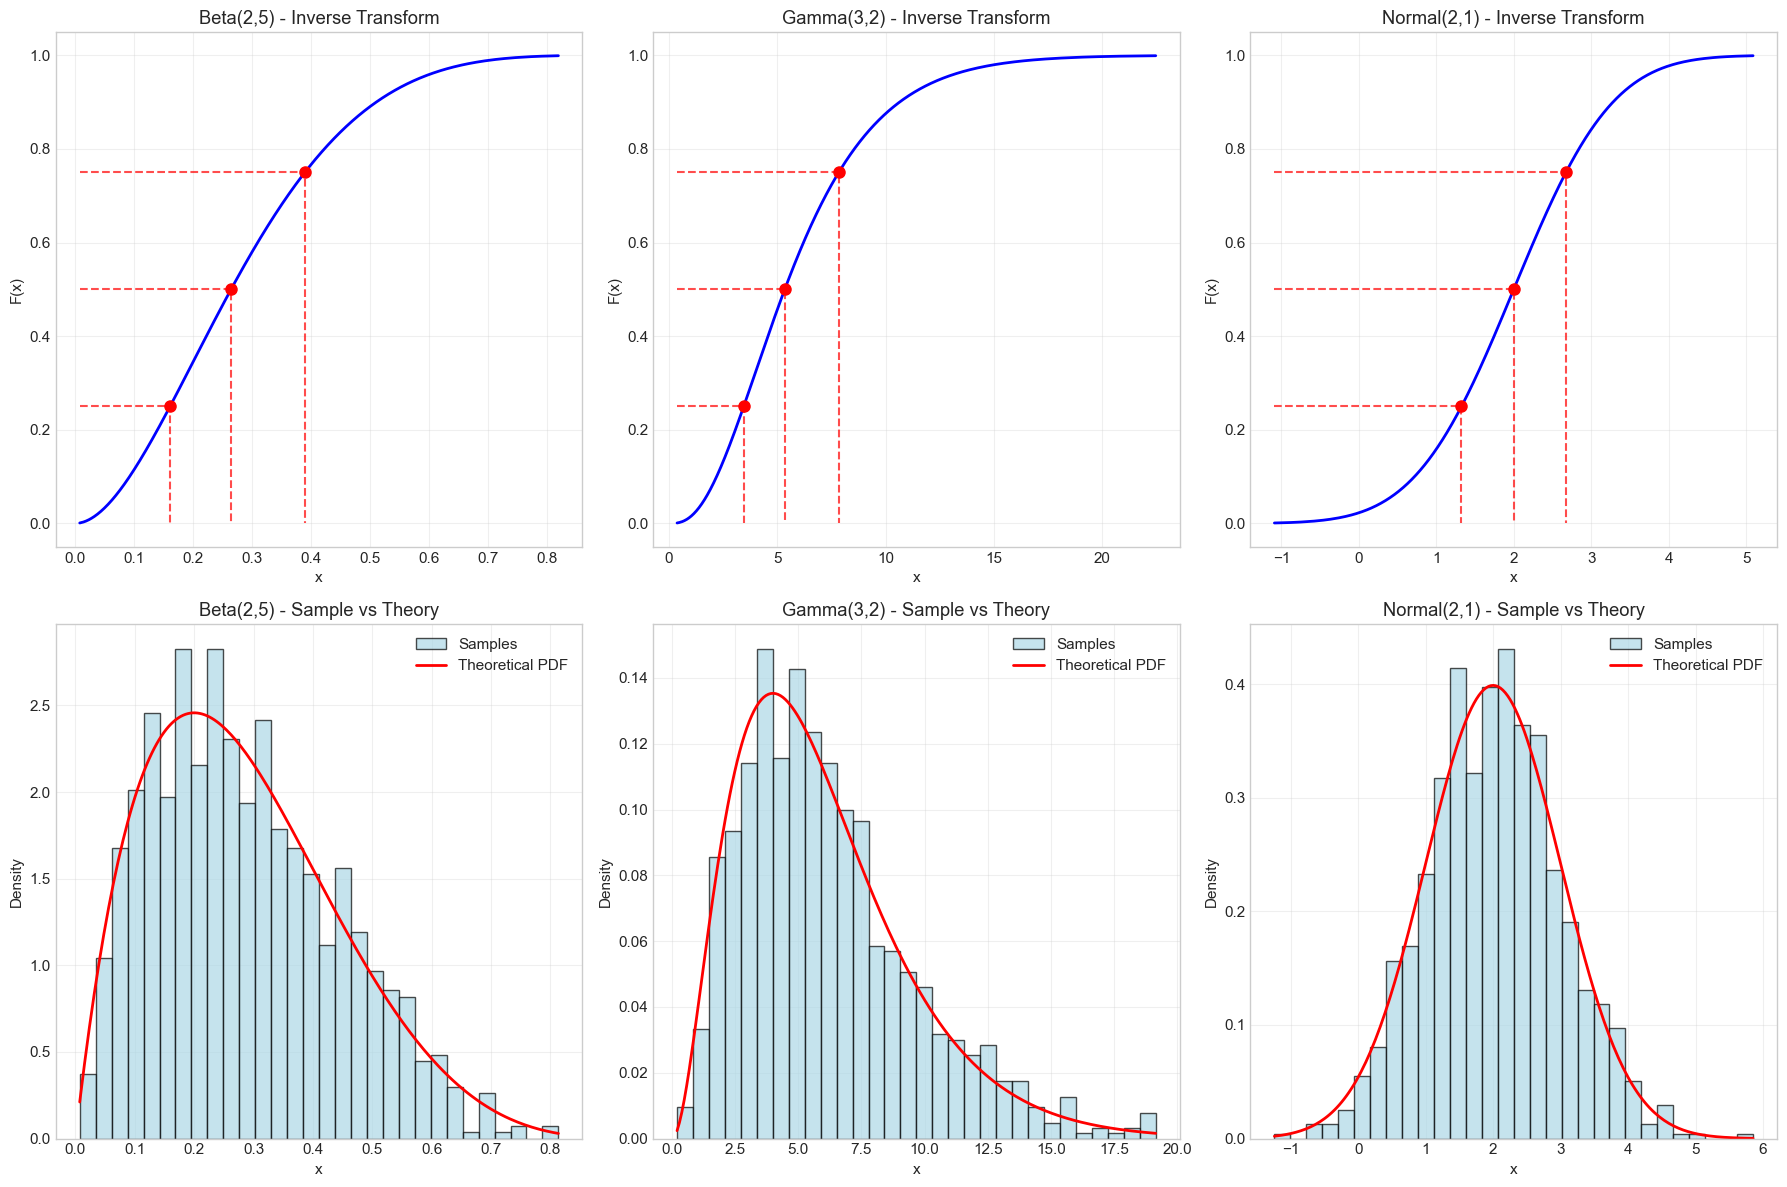

In [7]:
# Demonstrate with multiple distributions
distributions = [
    ("Beta(2,5)", stats.beta(2, 5)),
    ("Gamma(3,2)", stats.gamma(3, scale=2)),
    ("Normal(2,1)", stats.norm(2, 1)),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (name, dist) in enumerate(distributions):
    # Generate samples
    u_vals = np.linspace(0.001, 0.999, 1000)
    x_vals = dist.ppf(u_vals)

    # Top row: CDF with inverse transform arrows
    ax_top = axes[0, i]
    ax_top.plot(x_vals, u_vals, "b-", linewidth=2, label=f"{name} CDF")

    # Show a few transformation examples
    sample_u = [0.25, 0.5, 0.75]
    for u in sample_u:
        x = dist.ppf(u)
        ax_top.plot([min(x_vals), x, x], [u, u, 0], "r--", alpha=0.7)
        ax_top.plot(x, u, "ro", markersize=8)

    ax_top.set_title(f"{name} - Inverse Transform")
    ax_top.set_xlabel("x")
    ax_top.set_ylabel("F(x)")
    ax_top.grid(True, alpha=0.3)

    # Bottom row: Generated samples vs theoretical PDF
    ax_bottom = axes[1, i]
    samples = dist.rvs(1000, random_state=RANDOM_SEED)
    ax_bottom.hist(
        samples,
        bins=30,
        density=True,
        alpha=0.7,
        color="lightblue",
        edgecolor="black",
        label="Samples",
    )

    x_theory = np.linspace(np.min(samples), np.max(samples), 200)
    pdf_theory = dist.pdf(x_theory)
    ax_bottom.plot(x_theory, pdf_theory, "r-", linewidth=2, label="Theoretical PDF")
    ax_bottom.set_title(f"{name} - Sample vs Theory")
    ax_bottom.set_xlabel("x")
    ax_bottom.set_ylabel("Density")
    ax_bottom.legend()
    ax_bottom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Implementation Comparison: Gamma Distribution

We'll compare three methods for sampling from Gamma(shape=2.5, scale=1.5):
1. **Direct Sampling**: NumPy's built-in generator
2. **Analytical Inverse**: Using SciPy's percent point function
3. **Numerical Inverse**: Using MC-Lab's numerical inverse transform

In [8]:
# Gamma distribution parameters
SHAPE = 2.5
SCALE = 1.5
gamma_dist = stats.gamma(SHAPE, scale=SCALE)

# Theoretical properties
theoretical_mean = SHAPE * SCALE
theoretical_std = np.sqrt(SHAPE) * SCALE

print(f"Gamma distribution: shape={SHAPE}, scale={SCALE}")
print(f"Theoretical mean: {theoretical_mean:.3f}")
print(f"Theoretical std: {theoretical_std:.3f}")

# Sample sizes for comparison
N_SAMPLES = 10000
N_PERFORMANCE = 100000

Gamma distribution: shape=2.5, scale=1.5
Theoretical mean: 3.750
Theoretical std: 2.372


In [9]:
def method_1_direct_sampling(n: int, seed: int) -> np.ndarray:
    """Direct sampling using NumPy's gamma function."""
    rng = as_generator(seed)
    return rng.gamma(SHAPE, SCALE, n)


def method_2_analytical_inverse(n: int, seed: int) -> np.ndarray:
    """Analytical inverse using SciPy's ppf function."""
    rng = as_generator(seed)
    u = rng.uniform(0, 1, n)
    return gamma_dist.ppf(u)


def method_3_numerical_inverse(n: int, seed: int) -> np.ndarray:
    """Numerical inverse using MC-Lab implementation."""
    # Create numerical inverse transform sampler
    x_range = (0.001, gamma_dist.ppf(0.999))
    sampler = NumericalInverseTransformSampler(
        cdf=gamma_dist.cdf,
        x_range=x_range,
        method="interpolation",
        n_points=2000,
        random_state=seed,
    )
    return sampler.sample(n)


# Test implementations
print("Testing implementations...")
sample_test = 100
samples_1 = method_1_direct_sampling(sample_test, RANDOM_SEED)
samples_2 = method_2_analytical_inverse(sample_test, RANDOM_SEED)
samples_3 = method_3_numerical_inverse(sample_test, RANDOM_SEED)

print(f"Method 1 mean: {np.mean(samples_1):.3f}")
print(f"Method 2 mean: {np.mean(samples_2):.3f}")
print(f"Method 3 mean: {np.mean(samples_3):.3f}")
print("All methods working correctly!")

Testing implementations...
Method 1 mean: 3.571
Method 2 mean: 3.523
Method 3 mean: 3.527
All methods working correctly!


In [10]:
def evaluate_method(
    method_func: Callable, method_name: str, n_samples: int, seed: int
) -> dict:
    """Evaluate a sampling method for accuracy and performance."""
    # Performance timing
    start_time = time.time()
    samples = method_func(n_samples, seed)
    end_time = time.time()
    runtime = end_time - start_time
    samples_per_sec = n_samples / runtime

    # Statistical evaluation
    sample_mean = np.mean(samples)
    sample_std = np.std(samples)

    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.kstest(samples, gamma_dist.cdf)

    # Memory usage (approximate)
    memory_usage = samples.nbytes / (1024**2)  # MB

    return {
        "method": method_name,
        "sample_mean": sample_mean,
        "sample_std": sample_std,
        "theoretical_mean": theoretical_mean,
        "theoretical_std": theoretical_std,
        "ks_pvalue": ks_pvalue,
        "samples_per_sec": samples_per_sec,
        "memory_mb": memory_usage,
    }


# Evaluate all methods
methods = [
    (method_1_direct_sampling, "Direct"),
    (method_2_analytical_inverse, "Analytical"),
    (method_3_numerical_inverse, "Numerical"),
]

results = []
print("Evaluating methods (this may take a moment)...")

for method_func, method_name in methods:
    print(f"Testing {method_name}...")
    result = evaluate_method(method_func, method_name, N_PERFORMANCE, RANDOM_SEED)
    results.append(result)

print("Evaluation complete!")

Evaluating methods (this may take a moment)...
Testing Direct...
Testing Analytical...
Testing Numerical...
Evaluation complete!


In [11]:
# Create performance comparison table
import pandas as pd

df = pd.DataFrame(results)

# Format the table for display
formatted_df = df.copy()
formatted_df["sample_mean"] = formatted_df["sample_mean"].apply(lambda x: f"{x:.3f}")
formatted_df["sample_std"] = formatted_df["sample_std"].apply(lambda x: f"{x:.3f}")
formatted_df["theoretical_mean"] = formatted_df["theoretical_mean"].apply(
    lambda x: f"{x:.2f}"
)
formatted_df["theoretical_std"] = formatted_df["theoretical_std"].apply(
    lambda x: f"{x:.2f}"
)
formatted_df["ks_pvalue"] = formatted_df["ks_pvalue"].apply(lambda x: f"{x:.4f}")
formatted_df["samples_per_sec"] = formatted_df["samples_per_sec"].apply(
    lambda x: f"{x:,.0f}"
)
formatted_df["memory_mb"] = formatted_df["memory_mb"].apply(lambda x: f"{x:.2f}")

# Rename columns for display
formatted_df.columns = [
    "Method",
    "Sample Mean",
    "Sample Std",
    "Theoretical Mean",
    "Theoretical Std",
    "KS Test p-value",
    "Runtime (samples/sec)",
    "Memory Usage (MB)",
]

print("Performance Comparison Table:")
print("=" * 120)
print(formatted_df.to_string(index=False))
print("=" * 120)

print("\nInterpretation:")
print("- KS Test p-value > 0.05 indicates samples follow the expected distribution")
print("- Higher samples/sec indicates better performance")
print("- All methods should produce similar means and standard deviations")

Performance Comparison Table:
    Method Sample Mean Sample Std Theoretical Mean Theoretical Std KS Test p-value Runtime (samples/sec) Memory Usage (MB)
    Direct       3.752      2.384             3.75            2.37          0.7081            21,753,560              0.76
Analytical       3.754      2.372             3.75            2.37          0.3313             3,182,204              0.76
 Numerical       3.740      2.350             3.75            2.37          0.8299            19,150,324              0.76

Interpretation:
- KS Test p-value > 0.05 indicates samples follow the expected distribution
- Higher samples/sec indicates better performance
- All methods should produce similar means and standard deviations


## Summary and Key Takeaways

This notebook has demonstrated the theoretical foundations and practical applications of the inverse transform method:

### Key Theoretical Insights
1. **Fundamental Theorem**: F⁻¹(U) ~ F when U ~ Uniform(0,1)
2. **Probability Integral Transform**: F(X) ~ Uniform(0,1) when X ~ F
3. **Requirements**: Monotonic, invertible CDF

### Implementation Methods
1. **Analytical**: Fast, exact, requires closed-form inverse
2. **Numerical**: Flexible, slower, works with any CDF
3. **Stratified**: Variance reduction for Monte Carlo integration

### Performance Characteristics
- Direct methods are typically fastest
- Analytical inverse transform is competitive
- Numerical methods have setup overhead but are very flexible
- Stratified sampling provides significant variance reduction

### When to Use Inverse Transform
- Exact sampling requirements
- Variance reduction needs
- Quasi-Monte Carlo methods
- Coupling and reproducibility

The inverse transform method is a fundamental technique in Monte Carlo methods, providing both theoretical insights and practical sampling capabilities.